<a href="https://colab.research.google.com/github/yilin10/MusicalGenreClassification/blob/Knn/Copy_of_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Music Languages and System - Assignment 1

## Imports

Import of **Libraries**

In [0]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
from sklearn import neighbors, datasets
import IPython.display as ipd
import scipy as sp

Upload of your personal **Kaggle Api token** to enable download from Kaggle

In [2]:
from google.colab import files
files.upload() # Choose kaggle.json (your personal Kaggle API token)

! rm -r ~/.kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json # Change the permissions of the file.

rm: cannot remove '/root/.kaggle': No such file or directory


Download of the dataset from Kaggle

In [3]:
! pip install -q kaggle
! mkdir ~/dataset
! kaggle datasets download -d carlthome/gtzan-genre-collection
! unzip -q gtzan-genre-collection.zip -d ~/dataset

 99% 1.13G/1.14G [00:07<00:00, 173MB/s]
100% 1.14G/1.14G [00:07<00:00, 156MB/s]


We can get the dataset from kaggle, which includes 100 pieces of 30s audio from 10 different music genres provided by GTZAN. All the audio tracks are sampled at 22050 Hz Mono 16-bit audio files in .au format.

And in our task we need to classify Blues, Metal, Hip-Hop, Reggae.

## COMMIT TEST

In [0]:
# Insert Your_Name to do the First Commit Test here
#yilin Zhu

#Silvio
#Mattia
#Lorenzo

## Team Discussion
1. apply preprocessing to audio files
2. how to split our dataset to {training, testing} to make sure the difference of the two groups
3. check if our dataset is balanced? Actually it is already balanced.
4. which set of features can to useful for our cases
5. apply feature selection?
6. choose which classification method?
7. try different parameter for the classfier
8. evaluate the model
9. display the result

In [4]:
!unzip gtzan-genre-collection.zip

Archive:  gtzan-genre-collection.zip
  inflating: genres/blues/blues.00000.au  
  inflating: genres/blues/blues.00001.au  
  inflating: genres/blues/blues.00002.au  
  inflating: genres/blues/blues.00003.au  
  inflating: genres/blues/blues.00004.au  
  inflating: genres/blues/blues.00005.au  
  inflating: genres/blues/blues.00006.au  
  inflating: genres/blues/blues.00007.au  
  inflating: genres/blues/blues.00008.au  
  inflating: genres/blues/blues.00009.au  
  inflating: genres/blues/blues.00010.au  
  inflating: genres/blues/blues.00011.au  
  inflating: genres/blues/blues.00012.au  
  inflating: genres/blues/blues.00013.au  
  inflating: genres/blues/blues.00014.au  
  inflating: genres/blues/blues.00015.au  
  inflating: genres/blues/blues.00016.au  
  inflating: genres/blues/blues.00017.au  
  inflating: genres/blues/blues.00018.au  
  inflating: genres/blues/blues.00019.au  
  inflating: genres/blues/blues.00020.au  
  inflating: genres/blues/blues.00021.au  
  inflating: genr

## Training



In [0]:
#Funzione mfcc
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133.33,
        fmax=6853.8,
    )
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    return mfcc


In [53]:


    #Compute training features
    classes = ['blues', 'metal', 'hiphop', 'reggae']
    n_mfcc = 13
    dict_train_features = {'blues': [], 'metal': [], 'hiphop': [], 'reggae' : []}

    for c in classes:
      train_root = 'genres/{}/'.format(c)
      listaCompleta = os.listdir(train_root)
      trainList = listaCompleta[0:80]
      class_train_files = [f for f in trainList if f.endswith('.au')]
      n_train_samples = len(class_train_files)
      print(n_train_samples)
      train_features = np.zeros((n_train_samples, n_mfcc))

      for index, f in enumerate(class_train_files):
          audio, fs = librosa.load(os.path.join(train_root, f), sr=None)
          mfcc = compute_mfcc(audio, fs, n_mfcc)
          train_features[index, :] = np.mean(mfcc, axis=1)

      dict_train_features[c] = train_features




80
80
80
80


##Test

In [90]:
dict_test_features = {'blues': [], 'metal': [], 'hiphop': [], 'reggae' :[]}

for c in classes:
  test_root = 'genres/{}/'.format(c)
  listaCompleta = os.listdir(test_root)
  testList = listaCompleta[80:]
  class_test_files = [f for f in testList if f.endswith('.au')]
  n_test_samples = len(class_test_files)
  print(n_test_samples)
  test_features = np.zeros((n_test_samples, n_mfcc))

  for index, f in enumerate(class_test_files):
    audio, fs = librosa.load(os.path.join(test_root, f), sr=None)
    mfcc = compute_mfcc(audio, fs, n_mfcc)
    test_features[index, :] = np.mean(mfcc, axis=1)

  dict_test_features[c] = test_features

20
20
20
20


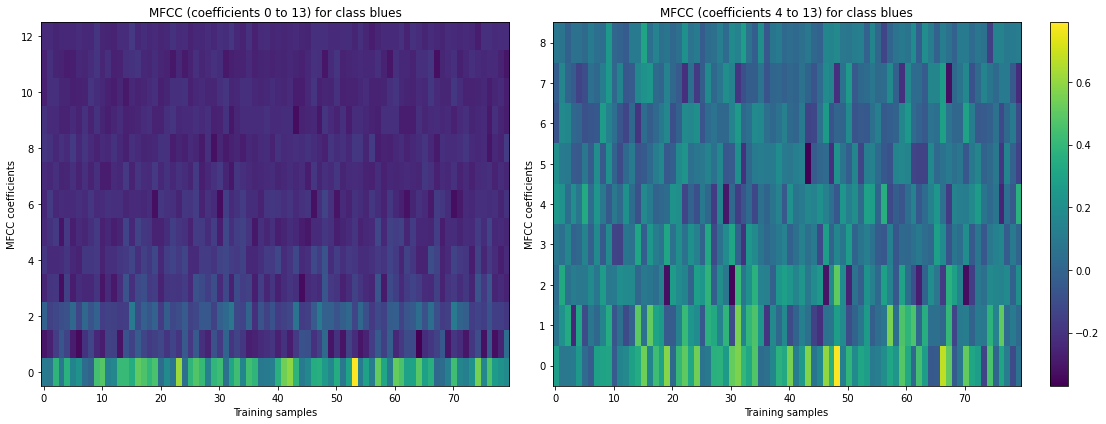

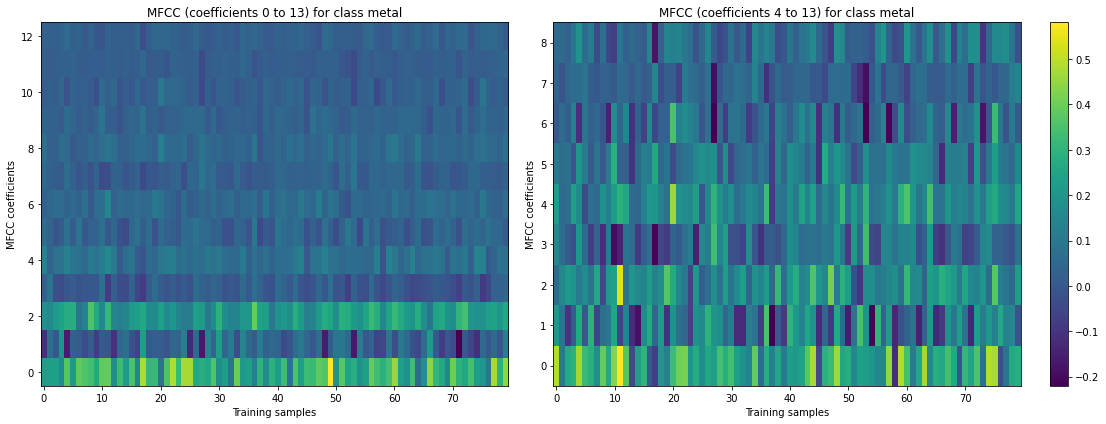

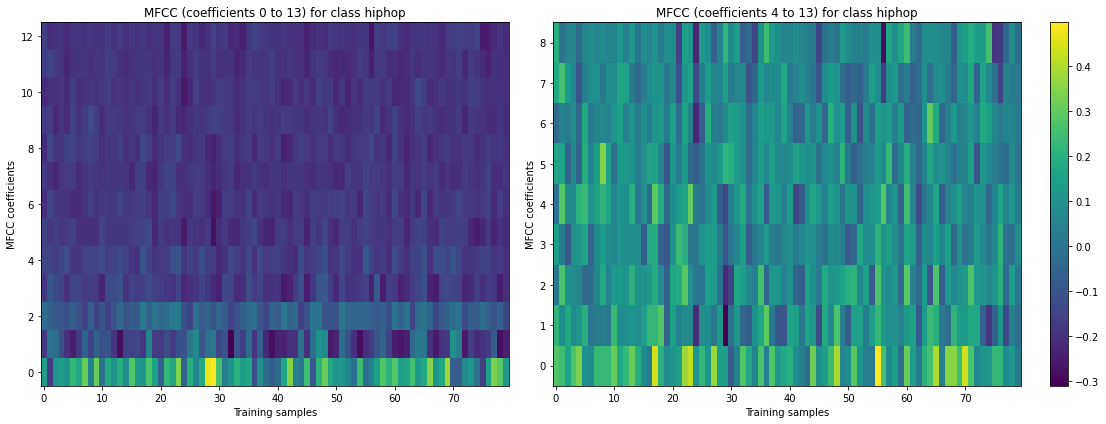

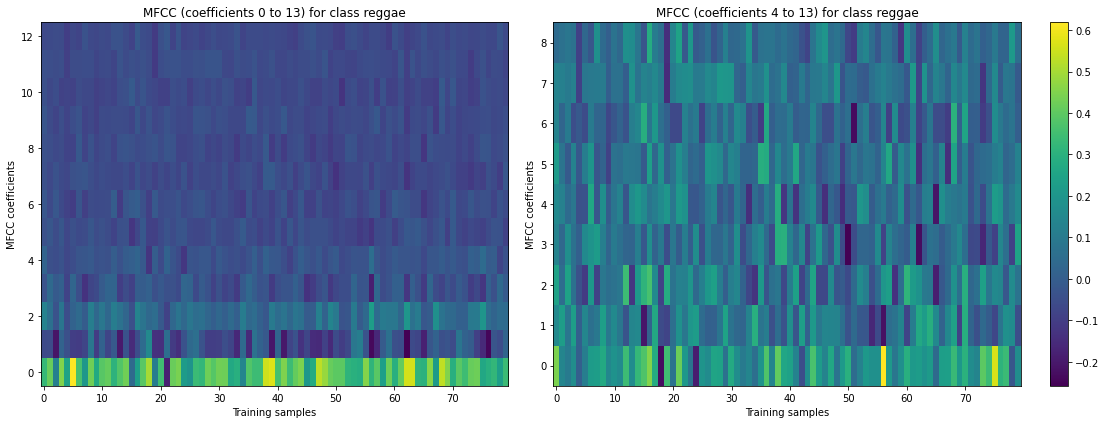

In [91]:
#visualization
for c in classes:
    mfcc = dict_train_features[c].transpose()
    # Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

In [78]:
dizionario  = {'uno':[], 'due': []}
dizionario['uno'] = np.array([[1,2,3],[4,5,6]])
dizionario['due'] = np.array([[7,8,9],[10,11,12]])

matrix = np.concatenate((dizionario['uno'],dizionario['due']), axis =0)
print(matrix)

trainFeatures = np.concatenate((dict_train_features['blues'],dict_train_features['metal'],dict_train_features['hiphop'], dict_train_features['reggae']), axis=0)
testFeatures = np.concatenate((dict_test_features['blues'],dict_test_features['metal'],dict_test_features['hiphop'], dict_test_features['reggae']), axis=1)



#labels
#definition of train labels for each genre (0 = blues, 1 = metal, 2 = disco, 3 = reggase)
dict_train_labels =  {'blues': [], 'metal': [], 'hiphop': [], 'reggae' : []}
i = 0
for c in classes:
  label = [i]
  labels = np.tile(label,80)
  dict_train_labels[c] = labels;
  i+=1

# definition of correct labels ( that are the labels of test files)
dict_correct_labels = {'blues': [], 'metal': [], 'hiphop': [], 'reggae' : []}
i = 0
for c in classes:
  label = [i]
  labels = np.tile(label,20)
  dict_correct_labels[c]= labels;
  i+=1

trainLabels =  np.concatenate((dict_train_labels ['blues'],dict_train_labels['metal'],dict_train_labels ['hiphop'],dict_train_labels['reggae']),axis =0)

print(np.shape(trainFeatures))
print(np.shape(trainLabels))


#correctLabels = np.concatenate((dict_correct_labels ['blues'],dict_correct_labels['metal'],dict_correct_labels ['hiphop'],dict_correct_labels['reggae']),axis =0)
#print(correctLabels)


[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
(320, 13)
(320,)


##kNN

In [101]:
#definition of train labels for each genre (0 = blues, 1 = metal, 2 = hiphop, 3 = reggase)
dict_train_labels =  {'blues': [], 'metal': [], 'hiphop': [], 'reggae' : []}
i = 0
for c in classes:
  label = [i]
  labels = np.tile(label,80)
  dict_train_labels[c] = labels;
  i+=1

# definition of correct labels ( that are the labels of test files)
dict_correct_labels = {'blues': [], 'metal': [], 'hiphop': [], 'reggae' : []}
i = 0
for c in classes:
  label = [i]
  labels = np.tile(label,20)
  dict_correct_labels[c]= labels;
  i+=1

#matrix of train features and labels for fitting the classifier
trainFeatures = np.concatenate((dict_train_features['blues'],dict_train_features['metal'],dict_train_features['hiphop'], dict_train_features['reggae']), axis=0)
trainLabels =  np.concatenate((dict_train_labels ['blues'],dict_train_labels['metal'],dict_train_labels ['hiphop'],dict_train_labels['reggae']),axis =0)

#matrix of test features and labels for final check
testFeatures = np.concatenate((dict_test_features['blues'],dict_test_features['metal'],dict_test_features['hiphop'], dict_test_features['reggae']), axis=0)
correctLabels = np.concatenate((dict_correct_labels ['blues'],dict_correct_labels['metal'],dict_correct_labels ['hiphop'],dict_correct_labels['reggae']),axis =0)

#create knn classifer
k = [5,8,10,15,20]
rate = np.zeros(5)
index = 0
for i in k:
  kClassifier = neighbors.KNeighborsClassifier(n_neighbors=i)
  kClassifier.fit(trainFeatures,trainLabels)

  predictedTestLabels = kClassifier.predict(testFeatures)
  
  #measure the performance
  correct = 0
  index2 = 0
  for j in predictedTestLabels:
    if j == correctLabels[index2]:
      correct += 1
    index2 +=1
  rate[index] = (correct/np.size(predictedTestLabels)) *100
  #
  print(rate[index])
  index += 1

print("The maximun rate is:")
print(max(rate))
print("which is achieved by")




The maximun rate is:
63.74999999999999
which is achieved by


## Optimization

## Conclusion